# Creating, training, and analyzing of **Extra-Trees Machine Learning model** for assessment of *Chl-a* in the Chesapeake Bay

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import timezone
from IPython.display import display
import folium

# Mount Google drive *- <u>should be removed in Binder application</u>*

In [2]:
from google.colab import drive
drive.mount('drive')
os.chdir('drive/MyDrive')

Mounted at drive


# Select the source of remotely sensed reflectances (*Rrs*) measured in parallel with *Chl-a*:

### *   Both *Rrs* and *Chl-a* measured **`in situ`**
### *   *Rrs* from **`MODIS-Aqua`** Level-2 satellite imagery matchups with in situ *Chl-a*  
### *   *Rrs* from **`VIIRS-SNPP`** Level-2 satellite imagery matchups with in situ *Chl-a*

In [49]:
# Comment/uncomment the source of Rrs vs. in situ Chl-a
rrs_source = 'In situ'
# rrs_source = 'MODIS-Aqua'
# rrs_source = 'VIIRS-SNPP'
print('Selected Rrs source: %s' % rrs_source)

Selected Rrs source: In situ


# Would you like to include:
### *   Latitude
### *   Season (month)
### *   Depth at sampling station (tot_depth)
### *   Distance offshore (dist_offshore)

In [51]:
# Create the list of additional features you would like to include into the model
# add_features = ['Latitude','month','dist_offshore','tot_depth']     # All 4 features included
# add_features = ['Latitude','month']                                 # Two features included
add_features = []                                                     # No additional features included
print('Additional features for modeling:', add_features)

Additional features for modeling: []


# Depending on your choices, prepare the dataframe for ML training

In [54]:

proj_dir = '/content/drive/MyDrive/Projects/2024_CHL_CPB' # In Binder application, proj_dir should be changed to '' (check!!!)
data_dir = 'Data'
cpbwq_myd_fn = 'CPBWQ_CHL_MODISA_DD.csv'
cpbwq_vii_fn = 'CPBWQ_CHL_VIIRS_DD.csv'
sbn_chl_myd_fn = 'SBN_CHL_MODISA_DD.csv'
sbn_chl_rrs_myd_fn = 'SBN_CHL_RRS_MODISA_DD.csv'
sbn_chl_rrs_vii_fn = 'SBN_CHL_RRS_VIIRS_DD.csv'
sbn_chl_vii_fn = 'SBN_CHL_VIIRS_DD.csv'
#
if rrs_source == 'In situ':
  chl_df = pd.read_csv(os.path.join(proj_dir, data_dir, sbn_chl_rrs_myd_fn))
  rrs_list = ['Rrs411', 'Rrs443', 'Rrs489', 'Rrs555', 'Rrs670']
  chl_df = chl_df[['lat', 'lon', 'chl', 'Chl_oc3s', 'datetime', 'dist_offshore', 'tot_depth']+rrs_list]
  chl_df = chl_df.rename(columns={'lat':'Latitude', 'lon':'Longitude', 'chl':'Chl_in_situ'})
  chl_df['datetime'] = pd.to_datetime(chl_df['datetime'],utc=True)
  chl_df.dropna(inplace=True)
elif rrs_source == 'MODIS-Aqua':
  rrs_list = ['Rrs_412', 'Rrs_443', 'Rrs_488', 'Rrs_531', 'Rrs_547', 'Rrs_667']
  chl_df1 = pd.read_csv(os.path.join(proj_dir, data_dir, sbn_chl_rrs_myd_fn))
  chl_df1 = chl_df1[['lat', 'lon', 'chl', 'Chl_oc3s', 'datetime', 'dist_offshore', 'tot_depth']+rrs_list]
  chl_df1 = chl_df1.rename(columns={'lat':'Latitude', 'lon':'Longitude', 'chl':'Chl_in_situ'})
  chl_df1['datetime'] = pd.to_datetime(chl_df1['datetime'],utc=True)
  chl_df2 = pd.read_csv(os.path.join(proj_dir, data_dir, cpbwq_myd_fn))
  chl_df2['datetime'] = chl_df2['Date'] + ' ' + chl_df2['Time']
  chl_df2 = chl_df2[['Latitude','Longitude','CHLA','chlor_a','datetime','dist_offshore','tot_depth']+rrs_list]
  chl_df2 = chl_df2.rename(columns={'CHLA':'Chl_in_situ','chlor_a':'Chl_oc3s'})
  chl_df2['datetime'] = pd.to_datetime(chl_df2['datetime'],utc=False)
  chl_df2['datetime'] = chl_df2['datetime'].dt.tz_localize('America/New_York').dt.tz_convert('Europe/London')
  chl_df3 = pd.read_csv(os.path.join(proj_dir, data_dir, sbn_chl_myd_fn))
  chl_df3 = chl_df3[['lat', 'lon', 'Chl_a', 'chlor_a', 'datetime', 'dist_offshore', 'tot_depth']+rrs_list]
  chl_df3 = chl_df3.rename(columns={'lat':'Latitude', 'lon':'Longitude', 'Chl_a':'Chl_in_situ','chlor_a':'Chl_oc3s'})
  chl_df3['datetime'] = pd.to_datetime(chl_df3['datetime'],utc=True)
  chl_df = pd.concat([chl_df1, chl_df2, chl_df3]).dropna()
elif rrs_source == 'VIIRS-SNPP':
  rrs_list = ['Rrs_410', 'Rrs_443', 'Rrs_486', 'Rrs_551', 'Rrs_671']
  chl_df1 = pd.read_csv(os.path.join(proj_dir, data_dir, sbn_chl_rrs_vii_fn))
  chl_df1 = chl_df1[['lat', 'lon', 'chl', 'Chl_oc3s', 'datetime', 'dist_offshore', 'tot_depth']+rrs_list]
  chl_df1 = chl_df1.rename(columns={'lat':'Latitude', 'lon':'Longitude', 'chl':'Chl_in_situ'})
  chl_df1['datetime'] = pd.to_datetime(chl_df1['datetime'],utc=True)
  chl_df2 = pd.read_csv(os.path.join(proj_dir, data_dir, cpbwq_vii_fn))
  chl_df2['datetime'] = chl_df2['Date'] + ' ' + chl_df2['Time']
  chl_df2 = chl_df2[['Latitude','Longitude','CHLA','chlor_a','datetime','dist_offshore','tot_depth']+rrs_list]
  chl_df2 = chl_df2.rename(columns={'CHLA':'Chl_in_situ','chlor_a':'Chl_oc3s'})
  chl_df2['datetime'] = pd.to_datetime(chl_df2['datetime'],utc=False)
  chl_df2['datetime'] = chl_df2['datetime'].dt.tz_localize('America/New_York').dt.tz_convert('Europe/London')
  chl_df3 = pd.read_csv(os.path.join(proj_dir, data_dir, sbn_chl_vii_fn))
  chl_df3 = chl_df3[['lat', 'lon', 'Chl_a', 'chlor_a', 'datetime', 'dist_offshore', 'tot_depth']+rrs_list]
  chl_df3 = chl_df3.rename(columns={'lat':'Latitude', 'lon':'Longitude', 'Chl_a':'Chl_in_situ','chlor_a':'Chl_oc3s'})
  chl_df3['datetime'] = pd.to_datetime(chl_df3['datetime'],utc=True)
  chl_df = pd.concat([chl_df1, chl_df2, chl_df3]).dropna()
print('Number of samples:', len(chl_df))

Number of samples: 399


# Display interactive map with *Chl-a* stations

In [55]:
location = [chl_df['Latitude'].mean(), chl_df['Longitude'].mean()]
bounds = [[chl_df['Latitude'].min(), chl_df['Longitude'].min()], [chl_df['Latitude'].max(), chl_df['Longitude'].max()]]
m = folium.Map(location=location, zoom_start=12, width="50%", height="80%")
for index, row in chl_df.iterrows():
  html_content = row['datetime'].strftime('%Y-%m-%d')+'<br>Chl='+'%.2f'%row['Chl_in_situ']
  popup = folium.Popup(html_content, max_width=300)
  folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=popup,
            opacity=1.0,
            icon=folium.Icon(color='purple'),
            radius=row['Chl_in_situ']*1.0
        ).add_to(m)
m.fit_bounds(bounds)
m

In [18]:
# print(len(chl_df))


(array([10.,  6.,  9.,  0.,  0.,  1.,  2.,  1.,  1.,  2.]),
 array([ 5. ,  6.5,  8. ,  9.5, 11. , 12.5, 14. , 15.5, 17. , 18.5, 20. ]),
 <BarContainer object of 10 artists>)

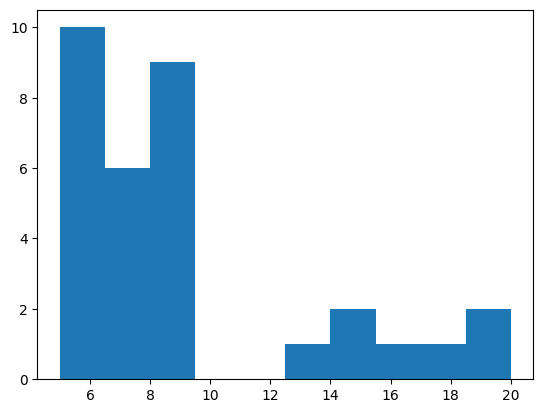

In [ ]:
plt.hist(chl_df3['datetime'].dt.tz_convert('America/New_York').dt.hour)